<a href="https://colab.research.google.com/github/AmitB30/cmr-haste/blob/main/ECGI_CMR_Segmentation_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!ssh-keygen -t rsa -b 4096

Generating public/private rsa key pair.
Enter file in which to save the key (/root/.ssh/id_rsa): 
Created directory '/root/.ssh'.
Enter passphrase (empty for no passphrase): 
Enter same passphrase again: 
Your identification has been saved in /root/.ssh/id_rsa.
Your public key has been saved in /root/.ssh/id_rsa.pub.
The key fingerprint is:
SHA256:cC9OsDrf2ttDnGVG22jemBDqKWxJmrRetdEvc/cxYQc root@e44c476ca77c
The key's randomart image is:
+---[RSA 4096]----+
|                 |
|          . . E  |
|      o .o o + . |
|    . .=+.o B .o.|
|   . *.+S=.X +. o|
|    +.*o+.* * oo |
|   .oo ... + . .o|
|    .o o ..     .|
|      o.+...     |
+----[SHA256]-----+


In [ ]:
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts

# github.com:22 SSH-2.0-babeld-01bfc857


In [ ]:
!cat /root/.ssh/id_rsa.pub

ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAACAQCa4Cho0mdVgctxxl+zvgMHs0feIjYY83rGYuar3aDDiRBrcDqGCPX/12sag5q5XYw/IXo0rXhinikoKVhAxFQw0RnCwlJ73GETA3PoUXoEq9BK4ae0o7PAE3eAtS/x94v0r80pLXIQ13HEPkBftcZUpHCYCXyNJ4EYKpoJkyGVMG6XjNN+7gSUfdojd2AkT/BMK32xCE0GcnnbQwBHQQjqrzMJg/PrnOxoEd9256bTZ8xAQAz4IWK6birlJfVHgOKsvApfGoqdyewFx9E1xSMq7BHB8sY9A95WhydLFEM1mPOc1Kwu+TX4kZ0pksVlG13FdM86lHZW3WMvoYtlBlB1RRGov2qqBrTQIOZ1sDGi5LC4b2XmNhEZws/DsrqXMjrLjHQ60HOecAFpXuBZ4Hy9cxX6OTS+vfMTffyu3chP1agAW4sN6iaXTQkoOIWlVCCIaSajyNl8hTdbe2OKiizO9AaF92T6cm1TXsgvjUse/cC4aYcSo24Usnddg/2dPvedwN+fdEPujx4EsXPbvtlHr0I1QIEW0+J3xHW+L8ppOaK7wQ+f0Cc0zYcDeUV3EoVy0HW9nmUCijBeJJxtWmiuTx5XJqwcZij703QxN3ZIVEB6Hw/MLN3lQyi3BKN/OHMvyg88Nso7AEaUhdsnpuP2whm7M1zS6w1KOniNfoUBJQ== root@e44c476ca77c


In [ ]:
!ssh -T git@github.com

Hi AmitB30! You've successfully authenticated, but GitHub does not provide shell access.


In [ ]:
!git clone git@github.com:AmitB30/cmr-haste

Cloning into 'cmr-haste'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 98 (delta 37), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (98/98), 210.43 KiB | 6.79 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [ ]:
%cd cmr-haste

/content/cmr-haste


In [ ]:
!pip install -e.

Obtaining file:///content/cmr-haste
  Running setup.py develop for cmr-haste


In [ ]:
!pip install monai
!pip install timm
!pip install tqdm

import argparse
import json
import logging
import os
from datetime import datetime
from uuid import uuid4
from collections import OrderedDict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import monai as M
import cv2
from tqdm import tqdm
from more_itertools import flatten
from monai.utils import set_determinism
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import UNet, BasicUNet
from monai.networks.utils import one_hot
from cv2 import findContours
from sklearn.model_selection import LeaveOneOut, KFold

from cmr_haste import utils
from cmr_haste.data import ImageDataset, ImageSegDataset, setup_data
from cmr_haste.losses import DiceLoss, dice_score

try:
    from torch.utils.tensorboard import SummaryWriter
    has_tb = True
except ImportError:
    has_tb = False
    
_logger = logging.getLogger('train')

     |████████████████████████████████| 721 kB 5.0 MB/s 
     |████████████████████████████████| 431 kB 4.5 MB/s 


#### Setup configuration and environment

In [ ]:
# Mount GDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = '/content/drive/My Drive/cmr-haste-main/cmr-haste-data'
out_root = '/content/drive/My Drive/cmr-haste-main/output/'
exp_name = '-'.join([datetime.now().strftime("%Y%m%d-%H%M%S"), 'seg-haste'])
exp_uid = str(uuid4)
resume = None
log_tb = True
device = 'cuda'
global_seed = 0
dataset_seed = 0
center_crop_size = (320, 320)
pad_size = (320, 320)
spatial_size = (320, 320)
rand_affine_prob = 0.3
rotate_range = 0.31415
shear_range = None
translate_range = 30
scale_range = 0.2
batch_size = 32
num_workers = 24
pin_memory = True
in_channels = 1
out_channels = 1
num_features = [16, 32, 64, 128, 256, 16]
lr = 0.001
weight_decay = 0.0001
seg_mode = 'binary'
val_metric = 'loss'
recovery_interval = None
num_epochs = 200

Set the global seed to ensure reproducibility:

In [ ]:
set_determinism(global_seed)

Setup output directories, logging, and tensorboard:

In [ ]:
output_dir, logs_dir, checkpoint_dir, recovery_dir = utils.get_out_dirs(out_root, exp_name)
utils.setup_default_logging(log_path=os.path.join(logs_dir, f'{exp_name}.log'))

In [ ]:
writer = None
if log_tb:
    if has_tb:
        writer = SummaryWriter(log_dir=logs_dir)
    else:
        _logger.warning("You've requested to log to tensorboard but module not found. "
                        "Nothing will be logged to tensorboard, try `pip install tensorboard`")

#### Setup data and transforms

In [ ]:
keys = ['image', 'seg']
transforms_train = M.transforms.Compose([
    M.transforms.AddChannelD(keys=keys),
    M.transforms.CenterSpatialCropD(keys=keys, roi_size=center_crop_size),
    M.transforms.SpatialPadD(keys=keys, spatial_size=pad_size),
    M.transforms.ResizeD(keys=keys, spatial_size=spatial_size, mode=['bilinear', 'nearest'], align_corners=[False, None]),
    M.transforms.ScaleIntensityD(keys=['image', 'seg'], minv=0, maxv=1),
    M.transforms.ToTensorD(keys=keys),

    M.transforms.RandRotated(keys=keys, range_x=90,prob=0.3,keep_size=True),
    M.transforms.RandAxisFlipd(keys=keys, prob=0.3),
    M.transforms.RandZoomd(keys=keys,min_zoom=0.9, max_zoom=1.5, prob=0.3),

])
transforms_test = M.transforms.Compose([
    M.transforms.AddChannelD(keys=keys),
    M.transforms.CenterSpatialCropD(keys=keys, roi_size=center_crop_size),
    M.transforms.SpatialPadD(keys=keys, spatial_size=pad_size),
    M.transforms.ResizeD(keys=keys, spatial_size=spatial_size, mode=['bilinear', 'nearest'], align_corners=[False, None]),
    M.transforms.ScaleIntensityD(keys=['image', 'seg'], minv=0, maxv=1),
    M.transforms.ToTensorD(keys=keys),
])

In [ ]:
with open(os.path.join(dataset_dir, 'metadata.json'), 'r') as f:
    meta = json.load(f)
data = meta['data']

In [ ]:
dataset_train, dataset_val, dataset_test = setup_data(
    root=dataset_dir,
    partition_data=True,
    train_split=0.5,
    val_split=0.25,
    test_split=0.25,
    train_transforms=transforms_train,
    val_transforms=transforms_test,
    test_transforms=transforms_test,
    seed=dataset_seed,
)

In [ ]:
#Get number of images/ patients in data sets
train_studies = []
val_studies = []
test_studies = []

i=0
for item in dataset_train.data:
  if dataset_train.data[i]['meta']['study_name'] not in train_studies:
    train_studies.append(dataset_train.data[i]['meta']['study_name'])
  i+=1
print("Train set contains", str(len(train_studies)), "patients:", train_studies)
print("Train set contains", str(len(dataset_train.data)), "images") #205 images
print("\n")

i=0
for item in dataset_val.data:
  if dataset_val.data[i]['meta']['study_name'] not in val_studies:
    val_studies.append(dataset_val.data[i]['meta']['study_name'])
  i+=1
print("Val set contains", str(len(val_studies)), "patients:", val_studies)
print("Val set contains", str(len(dataset_val.data)), "images") #205 images
print("\n")

i=0
for item in dataset_test.data:
  if dataset_test.data[i]['meta']['study_name'] not in test_studies:
    test_studies.append(dataset_test.data[i]['meta']['study_name'])
  i+=1
print("Test set contains", str(len(test_studies)), "patients:", test_studies)
print("Test set contains", str(len(dataset_test.data)), "images") #48 images

In [ ]:
#Plot Datasets
"""
# Plot train set
fig, axes = plt.subplots(16,10, figsize=(25,40))
try:
  for idx, ax in enumerate(axes.flatten()):
      ax.imshow(dataset_train[idx]['image'].squeeze().numpy().T, cmap='gray')
      ax.imshow(dataset_train[idx]['seg'].squeeze().numpy().T, alpha=0.3)

      ax.set_title("image "+str(idx))
      ax.set_axis_off()
except IndexError:
  pass

#Plot val set
fig, axes = plt.subplots(9,8, figsize=(40,45))
try:
  for idx, ax in enumerate(axes.flatten()):
      ax.imshow(dataset_val[idx]['image'].squeeze().numpy().T, cmap='gray')
      ax.imshow(dataset_val[idx]['seg'].squeeze().numpy().T, alpha=0.3)

      ax.set_title("image "+str(idx))
      ax.set_axis_off()
except IndexError:
  pass

#Plot test set
fig, axes = plt.subplots(9,8, figsize=(40,45))
try:
  for idx, ax in enumerate(axes.flatten()):
      ax.imshow(dataset_test[idx]['image'].squeeze().numpy().T, cmap='gray')
      ax.imshow(dataset_test[idx]['seg'].squeeze().numpy().T, alpha=0.3)

      ax.set_title("image "+str(idx))
      ax.set_axis_off()
except IndexError:
  pass

"""

'\n# Plot train set\nfig, axes = plt.subplots(16,10, figsize=(25,40))\ntry:\n  for idx, ax in enumerate(axes.flatten()):\n      ax.imshow(dataset_train[idx][\'image\'].squeeze().numpy().T, cmap=\'gray\')\n      ax.imshow(dataset_train[idx][\'seg\'].squeeze().numpy().T, alpha=0.3)\n\n      ax.set_title("image "+str(idx))\n      ax.set_axis_off()\nexcept IndexError:\n  pass\n\n#plt.savefig(\'/content/drive/My Drive/cmr-haste-main/plots/dataset_train.png\')\n\n\n#Plot val set\nfig, axes = plt.subplots(9,8, figsize=(40,45))\ntry:\n  for idx, ax in enumerate(axes.flatten()):\n      ax.imshow(dataset_val[idx][\'image\'].squeeze().numpy().T, cmap=\'gray\')\n      ax.imshow(dataset_val[idx][\'seg\'].squeeze().numpy().T, alpha=0.3)\n\n      ax.set_title("image "+str(idx))\n      ax.set_axis_off()\nexcept IndexError:\n  pass\n\nplt.savefig(\'/content/drive/My Drive/cmr-haste-main/plots/dataset_val.png\')\n\n\n#Plot test set\nfig, axes = plt.subplots(9,8, figsize=(40,45))\ntry:\n  for idx, ax in 

In [ ]:
dataloader_train = M.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
dataloader_val = M.data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
dataloader_test = M.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#####We'll plot some images to check image loading is working correctly:

In [ ]:
train_batch = next(iter(dataloader_train))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


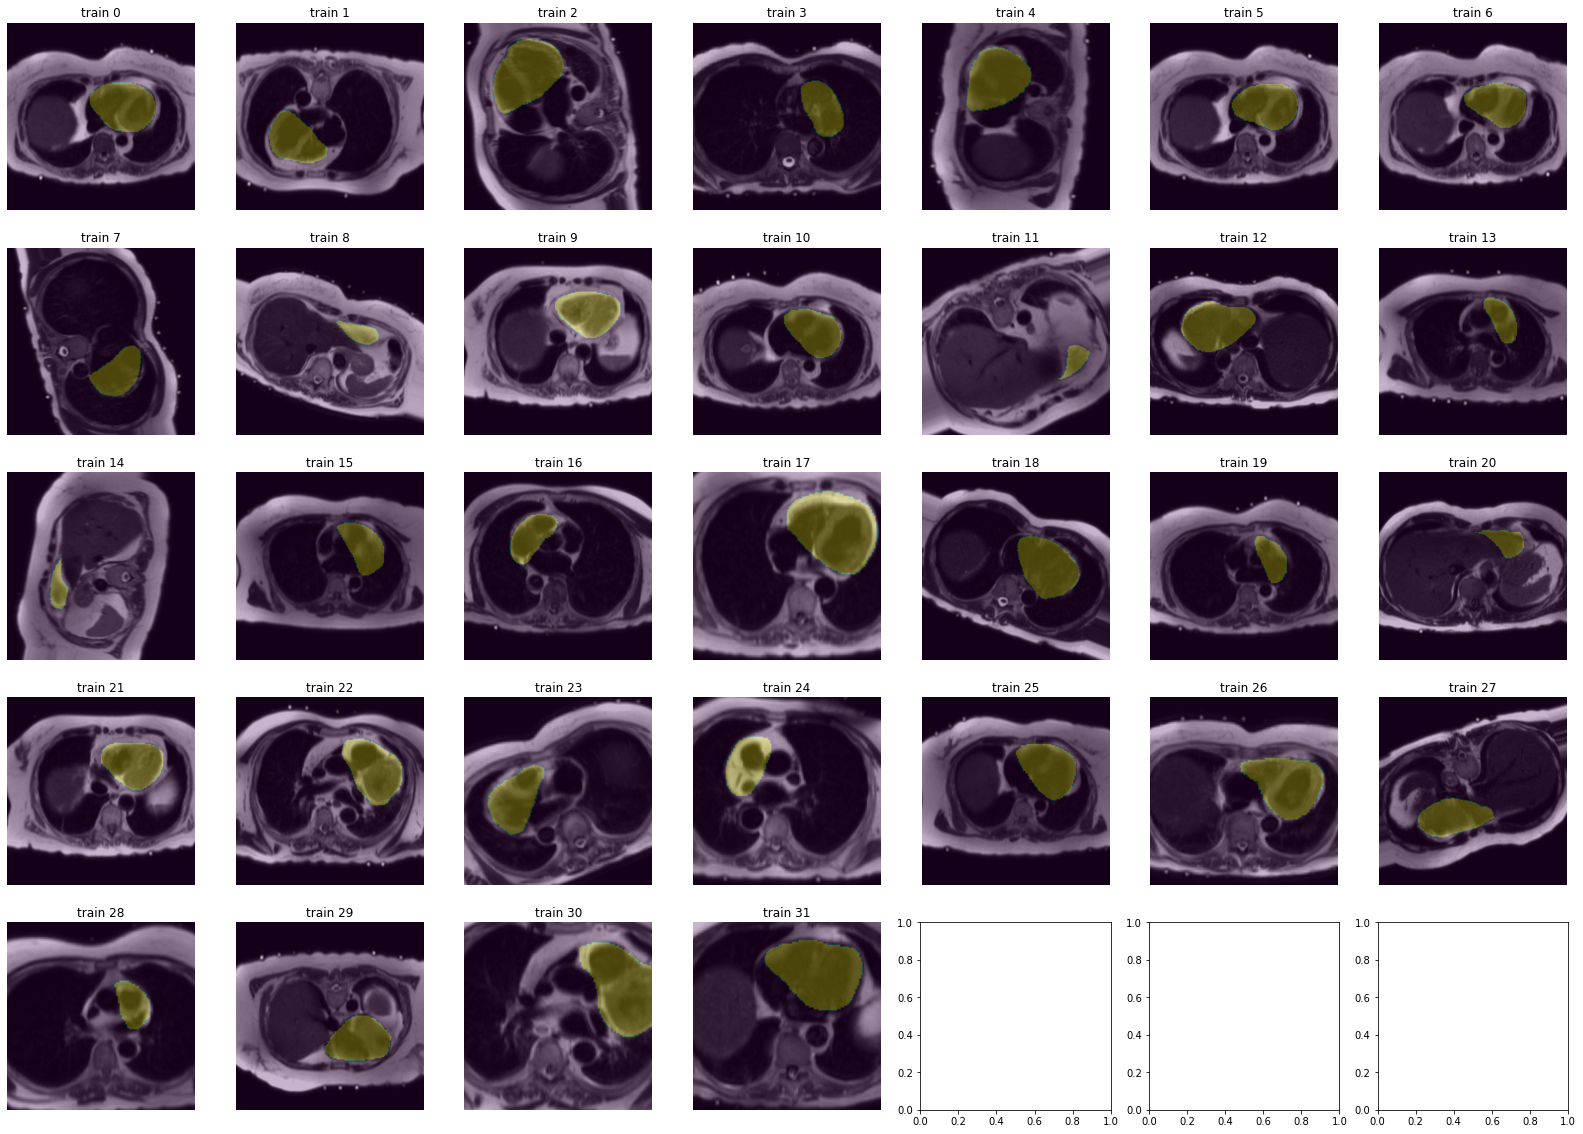

In [ ]:
#Plotting a batch of data from train set
fig, axes = plt.subplots(5,7, figsize=(28, 20))
try:
  for idx, ax in enumerate(axes.flatten()):
      #ax.imshow(np.moveaxis(batch['image'][idx].cpu().numpy(), 0, -1), cmap='gray')
      #ax.imshow(np.moveaxis(batch['seg'][idx].cpu().numpy(), 0, -1), alpha=0.3)
      ax.imshow(train_batch['image'][idx].cpu().squeeze().numpy().T, cmap='gray')
      ax.imshow(train_batch['seg'][idx].cpu().squeeze().numpy().T, alpha=0.3)
      ax.set_title('train '+str(idx))
      #you could also look at plt.contour()
      ax.set_axis_off()
except IndexError:
  pass

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


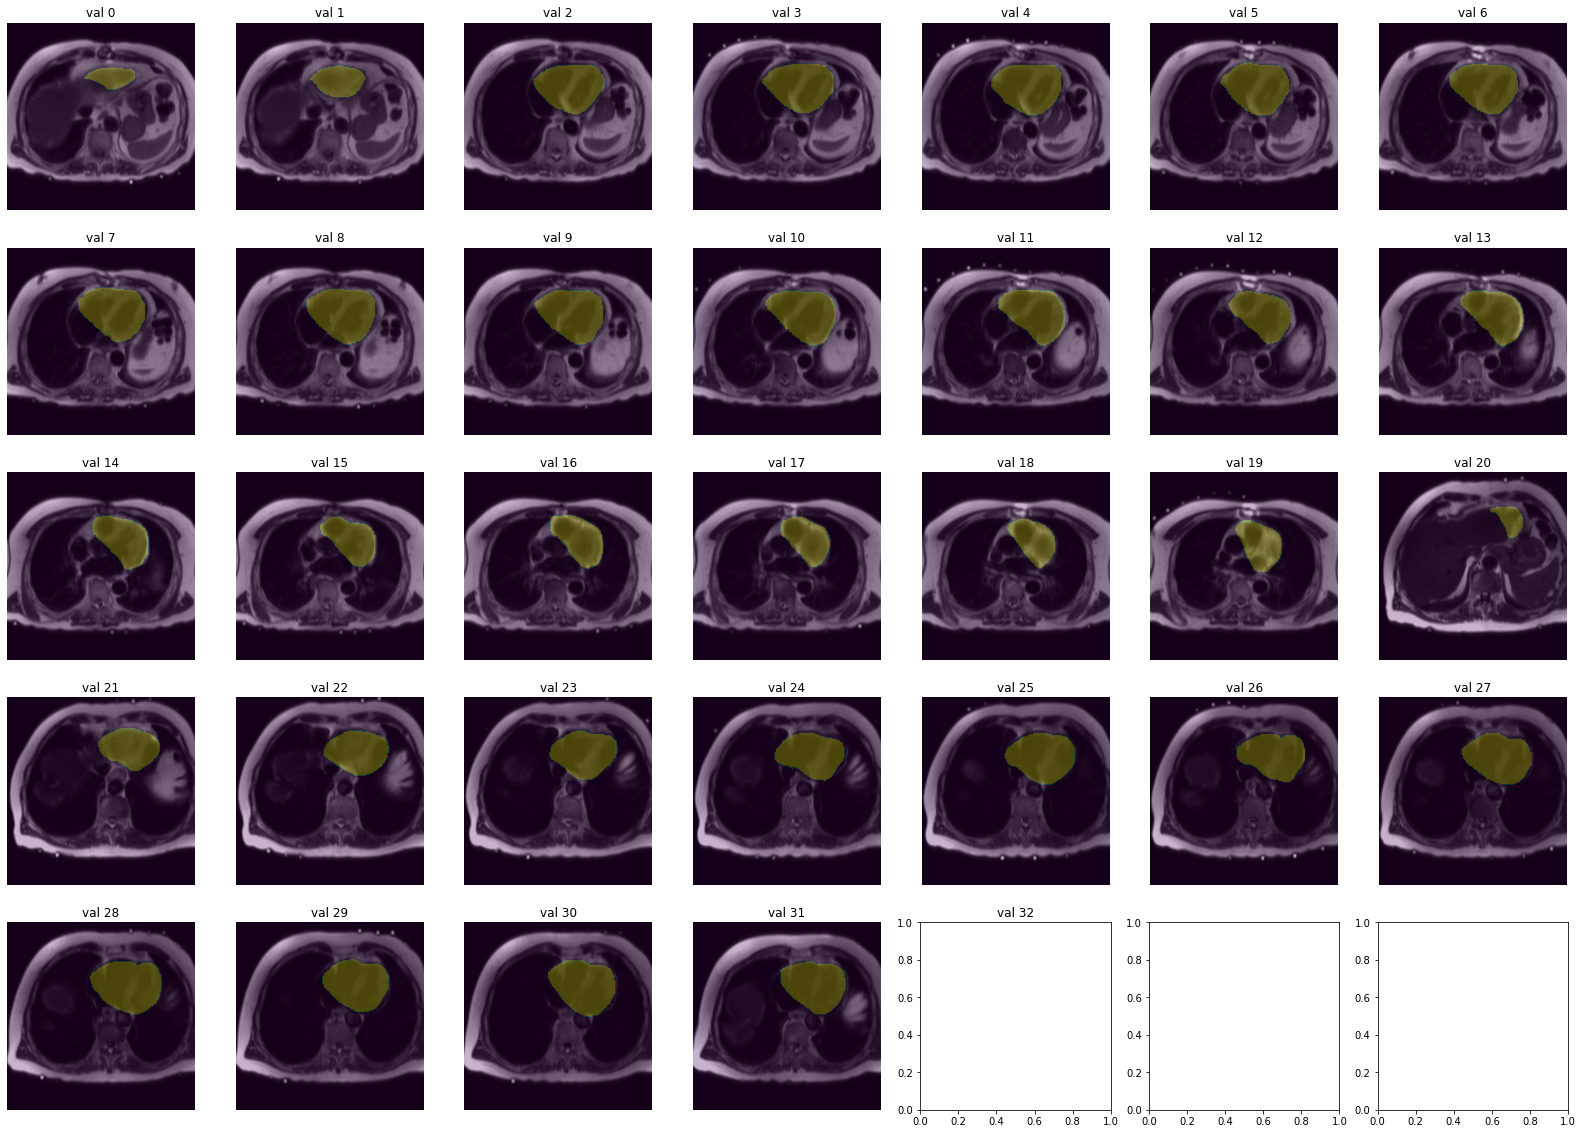

In [ ]:
#Plotting a batch of data from validation set
"""
val_batch = next(iter(dataloader_val))

fig, axes = plt.subplots(5,7, figsize=(28, 20))
try:
  for idx, ax in enumerate(axes.flatten()):
      #ax.imshow(np.moveaxis(batch['image'][idx].cpu().numpy(), 0, -1), cmap='gray')
      #ax.imshow(np.moveaxis(batch['seg'][idx].cpu().numpy(), 0, -1), alpha=0.3)
      ax.set_title('val '+str(idx))
      ax.imshow(val_batch['image'][idx].cpu().squeeze().numpy().T, cmap='gray')
      ax.imshow(val_batch['seg'][idx].cpu().squeeze().numpy().T, alpha=0.3)
    
      ax.set_axis_off()
except IndexError:
  pass
"""

#### Create the model -- we'll just use an implementation of UNet in MONAI for this

In [ ]:
model = BasicUNet(
    spatial_dims=2,
    in_channels=in_channels,
    out_channels=out_channels,
    features=num_features,
    act=('LeakyReLU', {'negative_slope': 0.1, 'inplace': True}),
    norm=('batch', {}),
    bias=True,
    dropout=0.0,
)
model_type = type(model).__name__
_logger.info(
    f'Model {model_type} created, param count:{sum([m.numel() for m in model.parameters()])}')

Model BasicUNet created, param count:1948129


BasicUNet features: (16, 32, 64, 128, 256, 16).


#### Create the optimizer and loss functions

In [ ]:
optimizer = torch.optim.Adam(
    params=model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
lr_scheduler = None
loss_fn_train = DiceLoss(mode=seg_mode)
loss_fn_val = DiceLoss(mode=seg_mode)

#### Setup checkpoint saver

In [ ]:
decreasing = True if val_metric == 'loss' else False
saver = utils.CheckpointSaver(
    model=model,
    optimizer=optimizer,
    checkpoint_dir=checkpoint_dir,
    recovery_dir=recovery_dir,
    decreasing=decreasing,
    max_history=5,
)

#### Now we train and validate the model

In [ ]:
def train_one_epoch(epoch, model, loader, opt, loss_fn, lr_scheduler=None, saver=None):
    
    losses_m = utils.AverageMeter()

    model.train()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    prog_bar = tqdm(loader, desc=f'Train epoch {epoch:{"0"}{">"}{4}}')
    for batch_idx, batch in enumerate(prog_bar):
        last_batch = batch_idx == last_idx

        image, seg = batch['image'].cuda(), batch['seg'].cuda()
        output = model(image)
        loss = loss_fn(output, seg)
        losses_m.update(loss.item(), image.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        num_updates += 1

        image_filename = ("train_epoch_"+str(epoch)+"_batch_"+str(batch_idx)+"_image")
        seg_filename = ("train_epoch_"+str(epoch)+"_batch_"+str(batch_idx)+"_seg")
        output_filename = ("train_epoch_"+str(epoch)+"_batch_"+str(batch_idx)+"_output")

        image = image.cpu().numpy()
        seg = seg.cpu().numpy()

        proba = torch.sigmoid(output)
        output = (proba >= 0.5) * 1
        output = output.cpu().detach().numpy()

        np.save(image_filename,image)
        np.save(seg_filename,seg)
        np.save(output_filename,output)


        if last_batch:
            pb_str = f'loss: {losses_m.avg:.6f}'
            if saver is not None and recovery_interval and (epoch + 1) % recovery_interval == 0:
                saver.save_recovery(epoch, batch_idx=batch_idx)
            if lr_scheduler is not None:
                lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)
        else:
            pb_str = f'loss: {losses_m.val:.6f}'

        prog_bar.set_postfix_str(pb_str)


    metrics = OrderedDict([('loss', losses_m.avg)])

    return metrics

In [ ]:
def validate(model, loader, loss_fn):

    losses_m = utils.AverageMeter()

    model.eval()
    last_idx = len(loader) - 1
    prog_bar = tqdm(loader, desc=f'{"Val":{""}{">"}{16}}')
    with torch.no_grad():
        for batch_idx, batch in enumerate(prog_bar):
            last_batch = batch_idx == last_idx

            image, seg = batch['image'].cuda(), batch['seg'].cuda()
            output = model(image)
            loss = loss_fn(output, seg)
            losses_m.update(loss.item(), image.size(0))

            image_filename = ("val_epoch_"+str(epoch)+"_batch_"+str(batch_idx)+"_image")
            seg_filename = ("val_epoch_"+str(epoch)+"_batch_"+str(batch_idx)+"_seg")
            output_filename = ("val_epoch_"+str(epoch)+"_batch_"+str(batch_idx)+"_output")

            image = image.cpu().numpy()
            seg = seg.cpu().numpy()

            proba = torch.sigmoid(output)
            output = (proba >= 0.5) * 1
            output = output.cpu().detach().numpy()

            np.save(image_filename,image)
            np.save(seg_filename,seg)
            np.save(output_filename,output)


            if last_batch:
                pb_str = f'loss: {losses_m.avg:.6f}'
            else:
                pb_str = f'loss: {losses_m.val:.6f}'
            prog_bar.set_postfix_str(pb_str)

    metrics = OrderedDict([('loss', losses_m.avg)])

    return metrics

In [ ]:
%cd cmr-haste

model = model.cuda()
metrics_train = []
metrics_val = []
best_metric = None
best_epoch = None
best_loss_val = np.inf
#num_epochs = 6
try:
    for epoch in range(0,num_epochs):

        train_out = train_one_epoch(epoch, model, dataloader_train, optimizer, loss_fn_train, lr_scheduler, saver)
        val_out = validate(model, dataloader_val, loss_fn_val)

        train_metrics = train_out
        val_metrics = val_out
        
        metrics_train.append(train_metrics)
        metrics_val.append(val_metrics)
        

        #print(train_metrics)
        #print(val_metrics)

        if lr_scheduler is not None:
            lr_scheduler.step(epoch, val_metrics[val_metric])

        if output_dir is not None:
            utils.update_summary(
                epoch, train_metrics, filename=os.path.join(logs_dir, 'summary.csv'), val_metrics=val_metrics,
                write_header=best_metric is None, writer=writer, log_wandb=False)
        
        if val_metrics['loss'] < best_loss_val:
            best_loss_val = val_metrics['loss']
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'loss': val_metrics['loss'],
              }

            save_path = checkpoint_dir + '/model_best_epoch_'+str(epoch)+'.pth'
            torch.save(checkpoint, save_path)
            best_model_path = save_path
            print(best_model_path)
        
        if saver is not None:
            save_metric = val_metrics[val_metric]
            best_metric, best_epoch = saver.save_checkpoint(epoch, metric=save_metric)

except KeyboardInterrupt:
    pass

if best_metric is not None:
    _logger.info(f'*** Best metric: {best_metric:.6f} (epoch {best_epoch})')

[Errno 2] No such file or directory: 'cmr-haste'
/content/cmr-haste


Train epoch 0000:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
             Val:   0%|          | 0/3 [00:00<?, ?it/s]Exception ignored in: <function _releaseLock at 0x7f2e569728c0>
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
             Val:   0%|          | 0/3 [00:04<?, ?it/s]


#### Plotting Predictions from our train and validation set:

In [ ]:
#Train Preds
train_epoch_images = []
train_epoch_segs = []
train_epoch_preds = []

start_epoch = 140
epochs = 10
end_epoch = (start_epoch+epochs)
for epoch_num in range(start_epoch,end_epoch):
  batch_images = []
  batch_segs = []
  batch_preds = []  
  for i in range (0,4):
    image = np.load('train_epoch_'+str(epoch_num)+'_batch_'+str(i)+'_image.npy')
    image = image[0,:,:,:]
    image = np.moveaxis(image,0,-1)

    seg = np.load('train_epoch_'+str(epoch_num)+'_batch_'+str(i)+'_seg.npy')
    seg = seg[0,:,:,:]
    seg = np.moveaxis(seg,0,-1)

    pred = np.load('train_epoch_'+str(epoch_num)+'_batch_'+str(i)+'_output.npy')
    pred = pred[0,:,:,:]
    pred = np.moveaxis(pred,0,-1)

    batch_images.append(image)
    batch_segs.append(seg)
    batch_preds.append(pred)

  train_epoch_images.append(batch_images)
  train_epoch_segs.append(batch_segs)
  train_epoch_preds.append(batch_preds)

epoch_range = end_epoch-start_epoch
for epoch_num in range(0,epoch_range):
  fig, axes = plt.subplots(1,4, figsize=(30,10))
  try:
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(train_epoch_images[epoch_num][idx].squeeze().T, cmap='gray')
        ax.imshow(train_epoch_segs[epoch_num][idx].squeeze().T, alpha=0.3)
        ax.set_title("epoch "+(str(start_epoch+epoch_num))+" image "+str(idx))
        ax.set_axis_off()
  except IndexError:
    pass

  image_name = "epoch_"+str(start_epoch+epoch_num)+"_input_1"
  #plt.savefig('/content/drive/My Drive/cmr-haste-main/plots/train_input/'+(image_name)+'.png')

  fig, axes = plt.subplots(1,4, figsize=(30,10))
  try:
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(train_epoch_images[epoch_num][idx].squeeze().T, cmap='gray')
        ax.imshow(train_epoch_preds[epoch_num][idx].squeeze().T, alpha=0.3)
        ax.set_title("epoch "+(str(start_epoch+epoch_num))+" out "+str(idx))
        ax.set_axis_off()
  except IndexError:
    pass

  image_name = "epoch_"+str(start_epoch+epoch_num)+"_output_1"
  #plt.savefig('/content/drive/My Drive/cmr-haste-main/plots/train_output/'+(image_name)+'.png')


#Clear lists to make space in RAM
train_epoch_images = []
train_epoch_segs = []
train_epoch_preds = []


In [ ]:
#Val Preds
val_epoch_images = []
val_epoch_segs = []
val_epoch_preds = []

start_epoch = 140
epochs = 10
end_epoch = (start_epoch+epochs)
for epoch_num in range(start_epoch,end_epoch):
  batch_images = []
  batch_segs = []
  batch_preds = []  
  for i in range (0,2):
    image = np.load('val_epoch_'+str(epoch_num)+'_batch_'+str(i)+'_image.npy')
    image = image[0,:,:,:]
    image = np.moveaxis(image,0,-1)

    seg = np.load('val_epoch_'+str(epoch_num)+'_batch_'+str(i)+'_seg.npy')
    seg = seg[0,:,:,:]
    seg = np.moveaxis(seg,0,-1)

    pred = np.load('val_epoch_'+str(epoch_num)+'_batch_'+str(i)+'_output.npy')
    pred = pred[0,:,:,:]
    pred = np.moveaxis(pred,0,-1)

    batch_images.append(image)
    batch_segs.append(seg)
    batch_preds.append(pred)

  val_epoch_images.append(batch_images)
  val_epoch_segs.append(batch_segs)
  val_epoch_preds.append(batch_preds)


epoch_range = end_epoch-start_epoch
for epoch_num in range(0,epoch_range):
  fig, axes = plt.subplots(1,2, figsize=(20,10))
  try:
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(val_epoch_images[epoch_num][idx].squeeze().T, cmap='gray')
        ax.imshow(val_epoch_segs[epoch_num][idx].squeeze().T, alpha=0.3)
        ax.set_title("epoch "+(str(start_epoch+epoch_num))+" image "+str(idx))
        ax.set_axis_off()
  except IndexError:
    pass
  
  image_name = "val_epoch_"+str(start_epoch+epoch_num)+"_input_1"
  #plt.savefig('/content/drive/My Drive/cmr-haste-main/plots/val_input/'+(image_name)+'.png')

  fig, axes = plt.subplots(1,2, figsize=(20,10))
  try:
    for idx, ax in enumerate(axes.flatten()):
        ax.imshow(val_epoch_images[epoch_num][idx].squeeze().T, cmap='gray')
        ax.imshow(val_epoch_preds[epoch_num][idx].squeeze().T, alpha=0.3)
        ax.set_title("epoch "+(str(start_epoch+epoch_num))+" out "+str(idx))
        ax.set_axis_off()
  except IndexError:
    pass

  image_name = "val_epoch_"+str(start_epoch+epoch_num)+"_output_1"
  #plt.savefig('/content/drive/My Drive/cmr-haste-main/plots/val_output/'+(image_name)+'.png')


val_epoch_images = []
val_epoch_segs = []
val_epoch_preds = []


#### Plot train and val losses

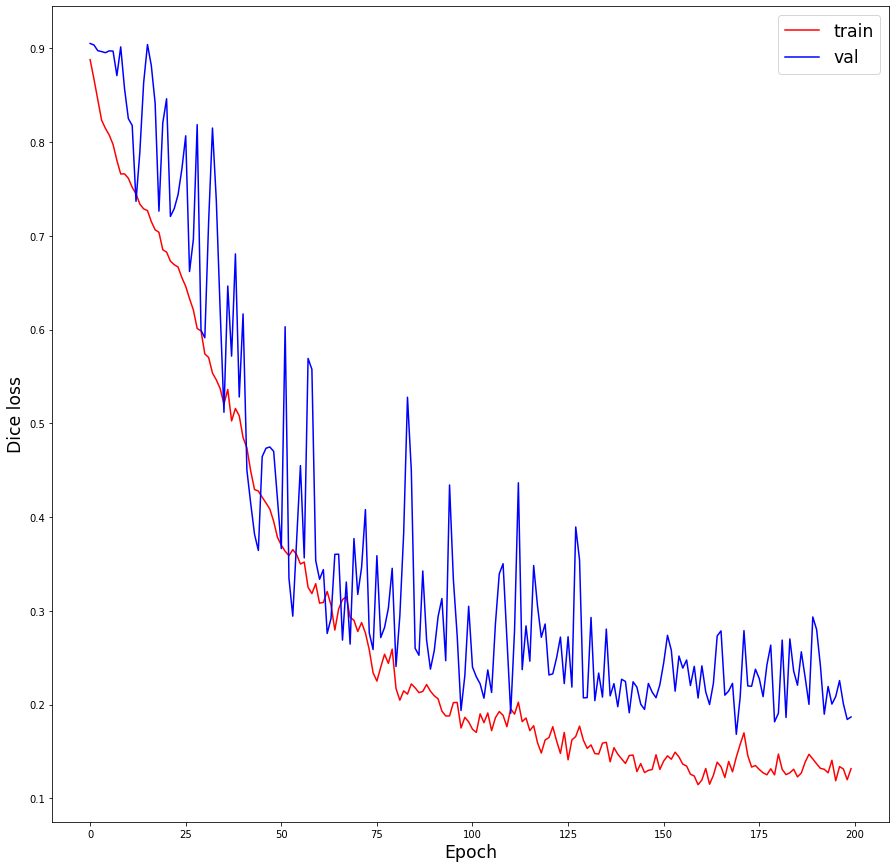

In [ ]:
train_losses = [i['loss'] for i in metrics_train]
val_losses = [i['loss'] for i in metrics_val]
best_val_loss =min(val_losses)
x = range(0, len(train_losses))

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
ax.plot(x, train_losses, c='r',label='train')
ax.plot(x, val_losses, c='b',label='val')
ax.set_xlabel('Epoch', fontsize='xx-large')
ax.set_ylabel('Dice loss', fontsize='xx-large')
ax.legend(fontsize='xx-large')
#ax.text(150,1.0, f'lr = {lr:.4}', fontsize='xx-large')

#image_name = "train_val_loss_graph_20220417-091638_epoch_157"
#image_name = "train_val_loss_graph_lr_0.01"
#plt.savefig('/content/drive/My Drive/cmr-haste-main/results/'+(image_name)+'.png')


#### Load the best model and evaluate on the test set

In [ ]:
ckpt = ('/content/drive/My Drive/cmr-haste-main/output/20220417-091638-seg-haste/checkpoints/model_best_epoch_157.pth')

model_best = utils.load_checkpoint(model, ckpt)
model = model.cuda()

Loaded model from checkpoint '/content/drive/My Drive/cmr-haste-main/output/20220417-091638-seg-haste/checkpoints/model_best_epoch_157.pth'


In [ ]:
loss_fn_test = DiceLoss(mode='binary', reduce=False)

In [ ]:
predict_seg = M.transforms.Compose([
    M.transforms.Activations(sigmoid=True),
    M.transforms.AsDiscrete(logit_thresh=0.5),
    M.transforms.KeepLargestConnectedComponent(applied_labels=[1], connectivity=1),
    M.transforms.FillHoles(applied_labels=[1], connectivity=1),
])

post_transforms = M.transforms.Compose([
    M.transforms.ToDeviceD(keys=['image', 'seg', 'output', 'loss', 'pred_seg' ,'dice'], device='cpu'),
    M.transforms.AsChannelLastD(keys=['image', 'seg', 'output', 'pred_seg']),
    M.transforms.ToNumpyD(keys=['image', 'seg', 'output', 'loss', 'pred_seg' ,'dice']),
])

decollate = M.transforms.Decollated()
to_cpu = M.transforms.ToNumpyD(keys=['image', 'seg', 'output', 'loss', 'pred_seg' ,'dice'])

In [ ]:
data_dicts = []
model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dataloader_test)):
        
        image, seg = batch.pop('image').cuda(), batch.pop('seg').cuda()
        output = model(image)
        loss = loss_fn_test(output, seg)
    
        batch_data_dicts = decollate({
            'image': image,
            'seg': seg,
            'output': output,
            'loss': loss,
            **batch,
        })
        
        for data_dict in batch_data_dicts:
            data_dict['pred_seg'] = predict_seg(data_dict['output'])
            data_dict['dice'] = dice_score(data_dict['pred_seg'], data_dict['seg'])
        batch_data_dicts = post_transforms(batch_data_dicts)
        data_dicts.extend(batch_data_dicts)

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


In [ ]:
for dd in data_dicts:
  
    img = np.moveaxis(dd.pop('image'), 0, 1)
    seg = np.moveaxis(dd.pop('seg'), 0, 1).astype(np.uint8)
    area_ventricles = np.sum(seg) * 1 / 100
    
    try:
        contour_ventricles = findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0][:, 0]
    except:
        contour_ventricles = []
    
    pred_seg = np.moveaxis(dd.pop('pred_seg'), 0, 1).astype(np.uint8)
    pred_area_ventricles = np.sum(pred_seg) * 1 / 100
    
    try:
        pred_contour_ventricles = findContours(pred_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[0][0][:, 0]
    except:
        pred_contour_ventricles = []
    
    
    dd['image'] = img
    dd['seg'] = seg
    dd['area_ventricles'] = area_ventricles
    dd['contour_ventricles'] = contour_ventricles
    
    dd['pred_seg'] = pred_seg
    dd['pred_area_ventricles'] = pred_area_ventricles
    dd['pred_contour_ventricles'] = pred_contour_ventricles
    

In [ ]:
study_dicts = utils.groupby(data_dicts, key=lambda x: x['meta']['study_name'])
study_dicts = {k: sorted(v, key=lambda x: x['meta']['image_number']) for k, v in study_dicts.items()}

In [ ]:
for study_name, dds in study_dicts.items():
    slice_max = max([i['meta']['slice_coord'] for i in dds])
    slice_min = min([i['meta']['slice_coord'] for i in dds])
    for dd in dds:
        dd['meta']['slice_coord_norm'] = (dd['meta']['slice_coord'] - slice_min) / (slice_max - slice_min)

In [ ]:
results = []
for studyname, dds in study_dicts.items():
    for dd in dds:
        results.append({
            'image_uid': dd['meta']['image_uid'],
            'area_ventricles': dd['area_ventricles'],
            'pred_area_ventricles': dd['pred_area_ventricles'],
            'dice': dd['dice'][0],
            'image_number': dd['meta']['image_number'],
            'slice_coord_norm': dd['meta']['slice_coord_norm'],
            'series_number': dd['meta']['series_number'],
            'sequence': dd['meta']['sequence'],
            'study_uid': dd['meta']['study_uid'],
            'study_name': dd['meta']['study_name'],
            'cohort': dd['meta']['cohort'],
        })
results = pd.DataFrame(results)

##### Plot figures

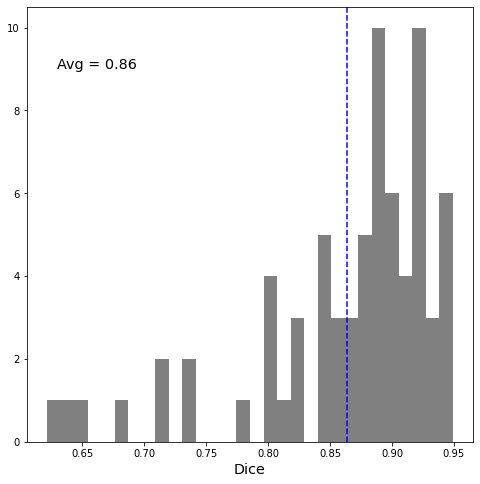

In [ ]:
mean_dice = np.mean(results.dice)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(results.dice, bins=30, color='grey')
ax.axvline(mean_dice, c='blue', linestyle='--')
ax.text(0.63, 9, f'Avg = {mean_dice:.2}', fontsize='x-large')
ax.set_xlabel('Dice', fontsize='x-large')
#plt.show()

image_name = "dice_graph_20220417-091638_epoch_157"
plt.savefig('/content/drive/My Drive/cmr-haste-main/results/'+(image_name)+'.png')

In [ ]:
results['area_ventricles_diff'] = results['area_ventricles'] - results['pred_area_ventricles']
results['area_ventricles_avg'] = (results['area_ventricles'] + results['pred_area_ventricles']) / 2.0
avg = np.mean(results['area_ventricles_diff'])
std = np.std(results['area_ventricles_diff'])
corr = np.corrcoef(results['area_ventricles'], results['pred_area_ventricles'])[0][1]

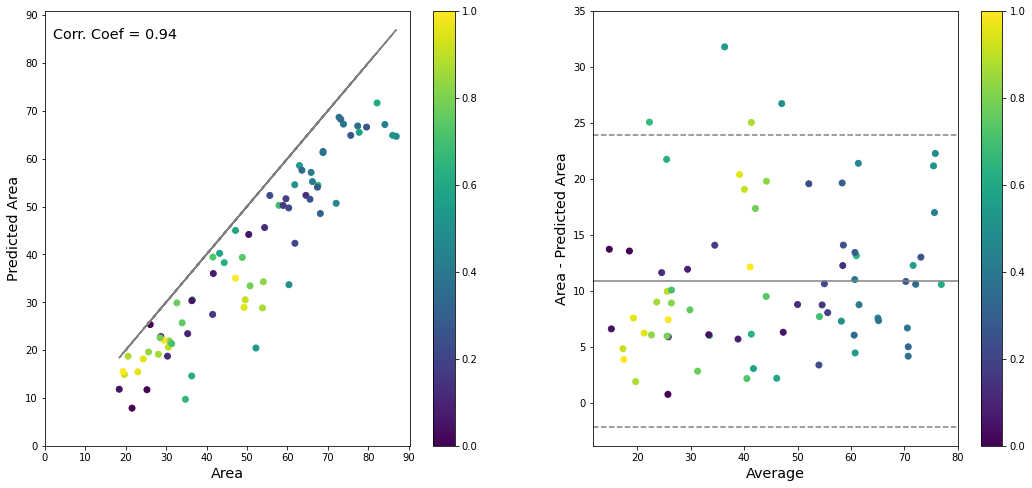

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Scatter plot of area vs predicted area
axes[0].plot(results['area_ventricles'], results['area_ventricles'], c='grey', linestyle='-')
im0=axes[0].scatter(results['area_ventricles'], results['pred_area_ventricles'], c=results.slice_coord_norm)
axes[0].set_xticks(range(0, 100, 10))
axes[0].set_yticks(range(0, 100, 10))
axes[0].text(2, 85, f'Corr. Coef = {corr:.2}', fontsize='x-large')
axes[0].set_xlabel('Area', fontsize='x-large')
axes[0].set_ylabel('Predicted Area', fontsize='x-large')

# Bland-Altman plot
im1=axes[1].scatter(results['area_ventricles_avg'], results['area_ventricles_diff'], c=results.slice_coord_norm)
axes[1].axhline(avg, c='grey')
axes[1].axhline(avg-1.96*std, c='grey', linestyle='--')
axes[1].axhline(avg+1.96*std, c='grey', linestyle='--')
axes[1].set_yticks(range(0, 40, 5))
axes[1].set_xlabel('Average', fontsize='x-large')
axes[1].set_ylabel('Area - Predicted Area', fontsize='x-large')

fig.colorbar(im0, ax=axes[0])
fig.colorbar(im1, ax=axes[1])

#image_name = "scatter_graph_20220417-091638_epoch_157"
#plt.savefig('/content/drive/My Drive/cmr-haste-main/results/'+(image_name)+'.png')

0.88721347
0.8425837904214859
0.9192807227373123
0.8634260296821594


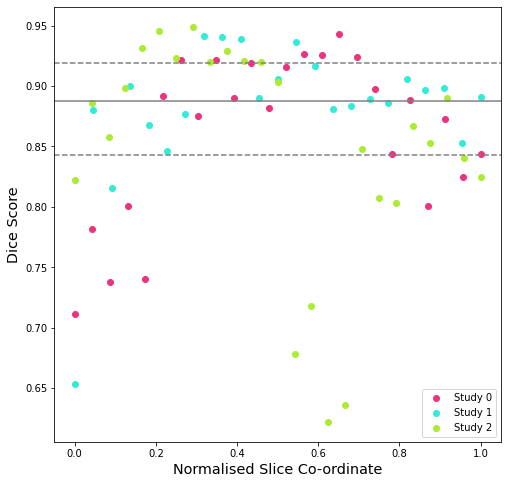

In [ ]:
median_dice = np.median(results.dice)
q1,q3 = np.percentile(results.dice,[25,75])

study_0 = studies[0]
study_1 = studies[1]
study_2 = studies[2]

dice_vals_0 = results.loc[results['study_name']==study_0,['dice']]
slice_vals_0 = results.loc[results['study_name']==study_0,['slice_coord_norm']]

dice_vals_1 = results.loc[results['study_name']==study_1,['dice']]
slice_vals_1 = results.loc[results['study_name']==study_1,['slice_coord_norm']]

dice_vals_2 = results.loc[results['study_name']==study_2,['dice']]
slice_vals_2 = results.loc[results['study_name']==study_2,['slice_coord_norm']]


fig, ax = plt.subplots(1, 1, figsize=(8, 8))
#im = ax.scatter(results['slice_coord_norm'],results['dice'], c=results.slice_coord_norm)
im = ax.scatter(slice_vals_0,dice_vals_0, c='#eb347d', label = "Study 0")
im = ax.scatter(slice_vals_1,dice_vals_1, c='#34ebd9', label = "Study 1")
im = ax.scatter(slice_vals_2,dice_vals_2, c='#abeb34', label = "Study 2")

ax.axhline(y=median_dice, c='gray', linestyle='-')
ax.axhline(y=q1, c='gray', linestyle='--')
ax.axhline(y=q3, c='gray', linestyle='--')
ax.set_xlabel('Normalised Slice Co-ordinate', fontsize='x-large')
ax.set_ylabel('Dice Score', fontsize='x-large')

ax.legend(loc='lower right')

image_name = "dice analysis"
#plt.savefig('/content/drive/My Drive/cmr-haste-main/results/'+(image_name)+'.png')

print(median_dice)
print(q1)
print(q3)
print(mean_dice)

In [ ]:
studies = list(study_dicts.keys())

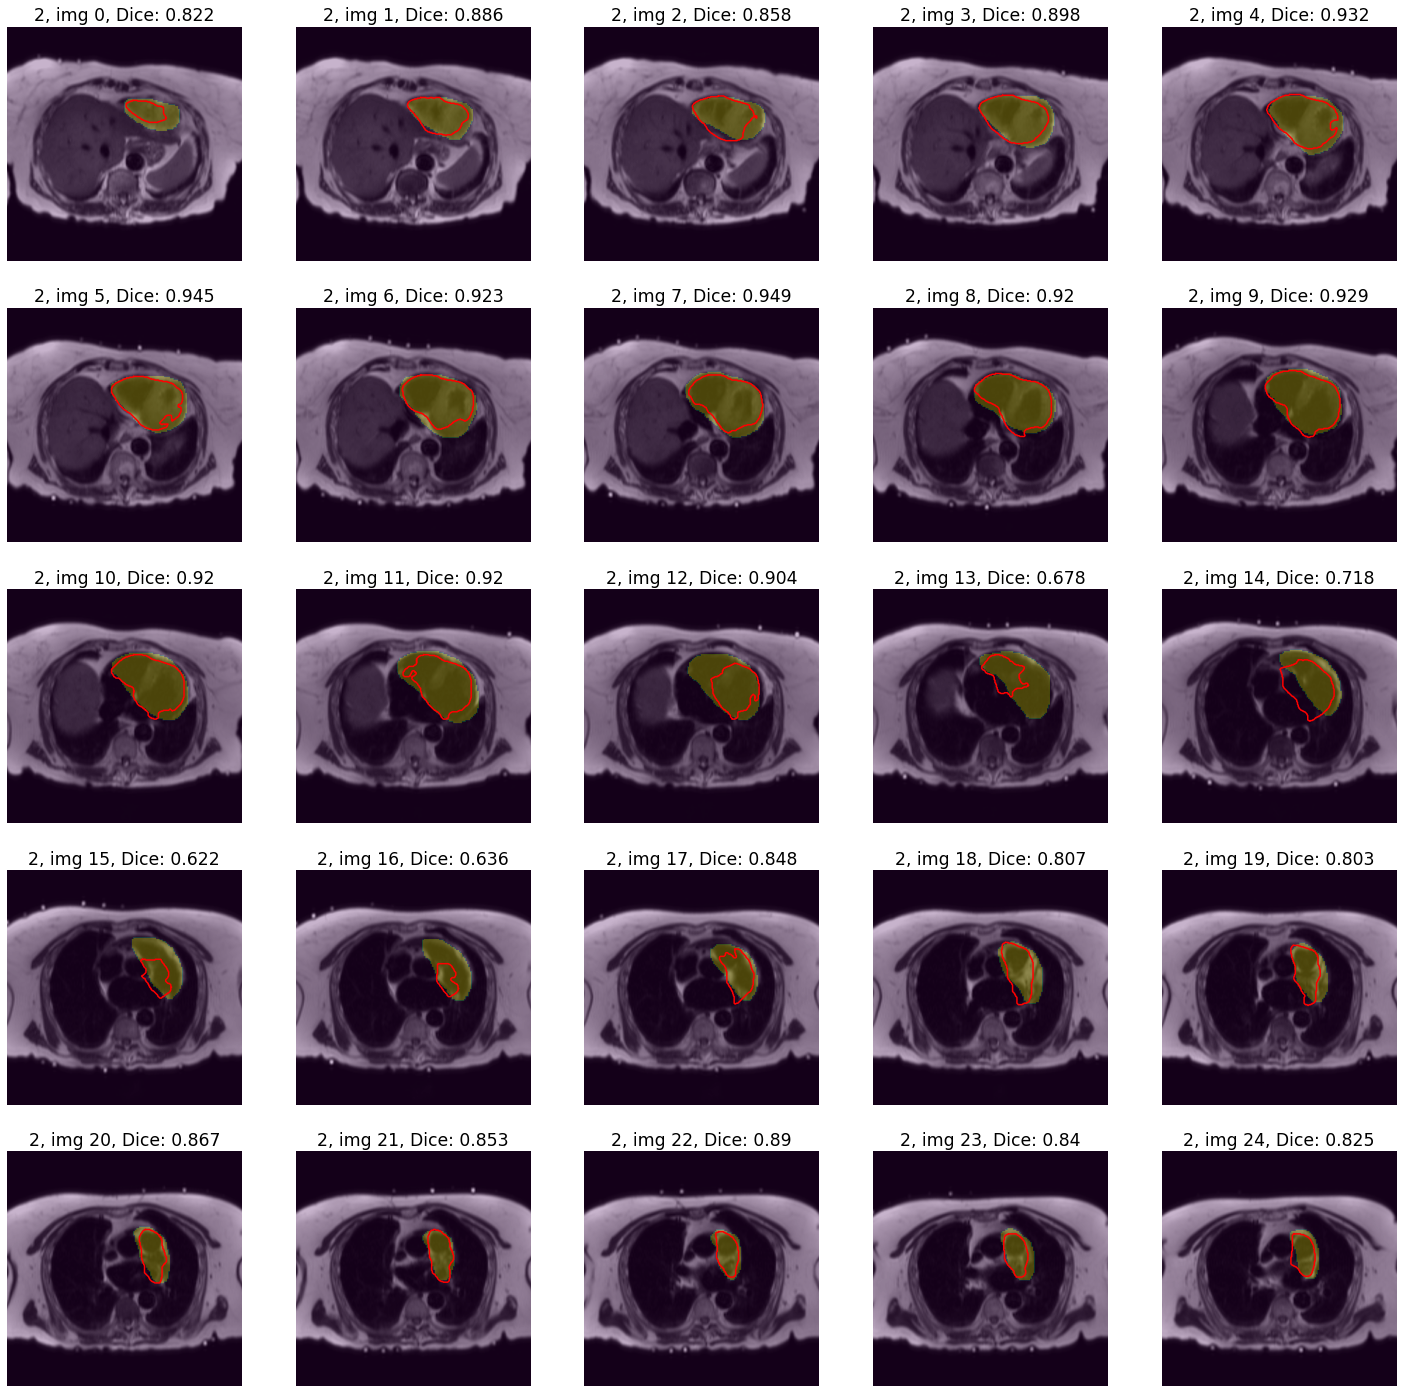

In [ ]:
# To plot all predictions for single study
study = studies[0]
#num_slices = print(len(study_dicts[study]))

#for slice_idx in range(0,num_slices):
fig, axes = plt.subplots(5,5, figsize=(25,25))
try:
  for idx, ax in enumerate(axes.flatten()):
      ax.imshow(study_dicts[study][idx]['image'].squeeze(), cmap='gray')
      ax.imshow(study_dicts[study][idx]['seg'].squeeze(), alpha =0.3)
      #ax.plot(study_dicts[study][idx]['contour_ventricles'][:,1], study_dicts[study][idx]['contour_ventricles'][:,0], c='r')
      ax.plot(study_dicts[study][idx]['pred_contour_ventricles'][:, 0], study_dicts[study][idx]['pred_contour_ventricles'][:, 1], c='r')
      
      dice = (study_dicts[study][idx]['dice'][0])
      
      ax.set_title((str(2))+", img "+str(idx)+", "+ f'Dice: {dice:.3}' ,fontsize='xx-large')
      ax.set_axis_off()
except IndexError:
  pass

#image_name = ("test_preds_2_"+(str(study)))
#plt.savefig('/content/drive/My Drive/cmr-haste-main/results/'+(image_name)+'.png')

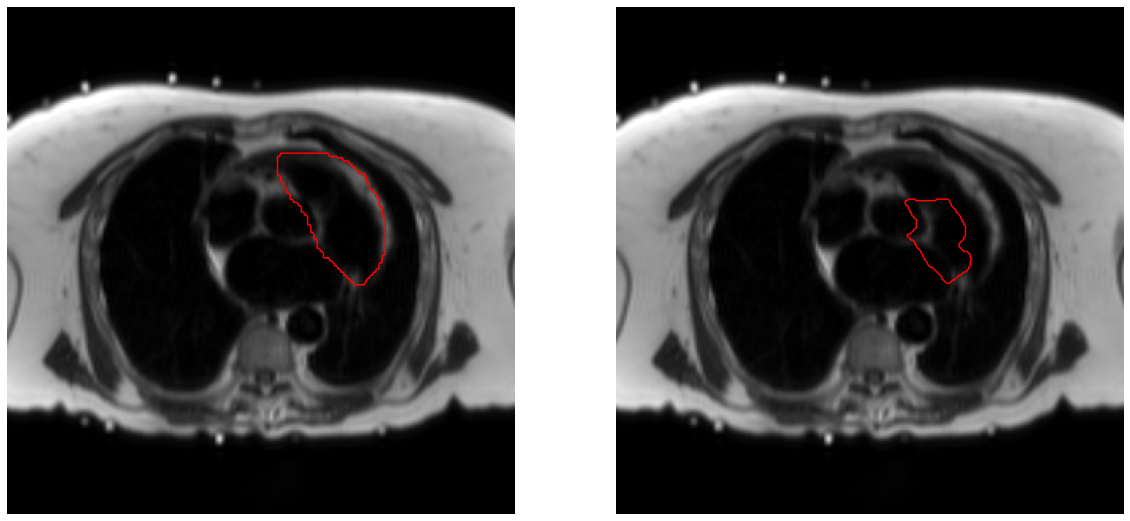

In [ ]:
study = studies[0]
slice_idx = 15
fig, axes = plt.subplots(1, 2, figsize=(20,20))
axes[0].imshow(study_dicts[study][slice_idx]['image'].squeeze(), cmap='gray')
axes[0].plot(study_dicts[study][slice_idx]['contour_ventricles'][:, 0], study_dicts[study][slice_idx]['contour_ventricles'][:, 1], c='r')
axes[1].imshow(study_dicts[study][slice_idx]['image'].squeeze(), cmap='gray')
axes[1].plot(study_dicts[study][slice_idx]['pred_contour_ventricles'][:, 0], study_dicts[study][slice_idx]['pred_contour_ventricles'][:, 1], c='r')
axes[0].set_axis_off()
axes[1].set_axis_off()

#image_name = ("test_2_worst"+(str(study)))
#plt.savefig('/content/drive/My Drive/cmr-haste-main/results/'+(image_name)+'.png')